# Temperature Data Analysis
### This is a notebook analyzing temperature data from the ERA5 dataset.

In [2]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
import rasterio
from rasterio.transform import from_origin
import rioxarray

In [3]:
# Load the temperature data
temperature_data = xr.open_dataset("Data/2m-temp-2014-2024-full.nc")

# Display the dataset structure to verify it loaded correctly
print(temperature_data)

<xarray.Dataset> Size: 8MB
Dimensions:     (valid_time: 96432, latitude: 4, longitude: 4)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 771kB 2014-01-01 ... 2024-12-31T2...
  * latitude    (latitude) float64 32B 25.12 24.88 24.62 24.38
  * longitude   (longitude) float64 32B 46.38 46.62 46.88 47.12
    expver      (valid_time) <U4 2MB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 6MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-27T11:10 GRIB to CDM+CF via cfgrib-0.9.1...


In [4]:
temperature = temperature_data["t2m"]

# Convert from Kelvin to Celsius
temperature_celsius = temperature - 273.15

In [5]:
# Calculate basic statistics
print("Max Temperature:", temperature_celsius.max().values)
print("Min Temperature:", temperature_celsius.min().values)


Max Temperature: 47.965728759765625
Min Temperature: -1.287322998046875


In [6]:
# Define path to the output folder relative to the notebook
output_folder = "Outputs_Heat"

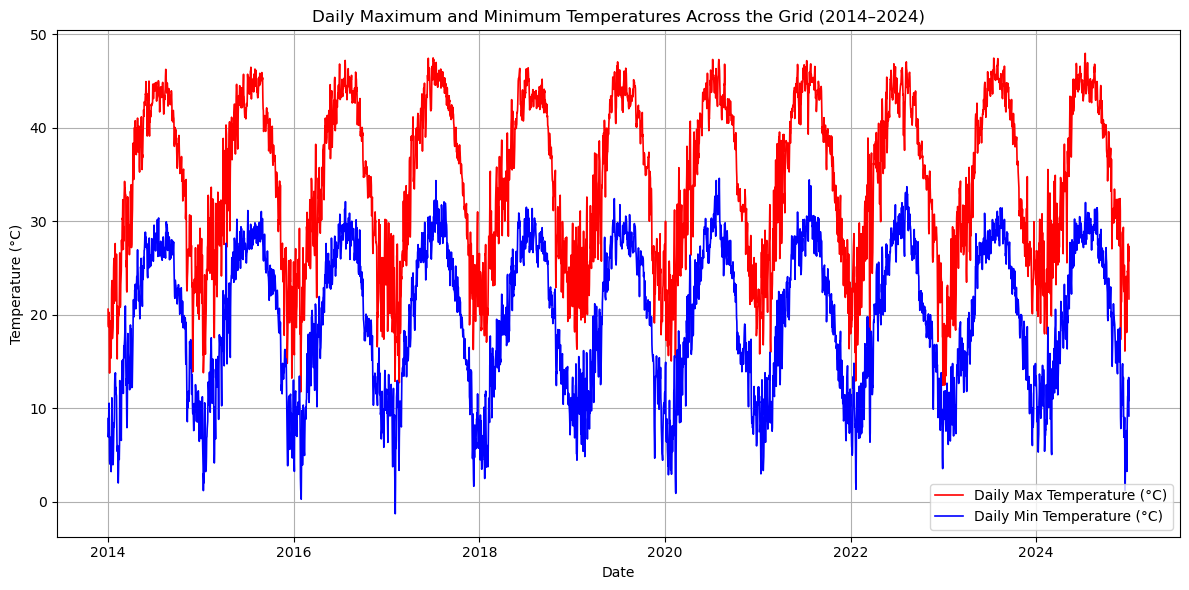

In [7]:
# Step 1: Resample to daily max and min temperatures
daily_max_temp = temperature_celsius.resample(valid_time="1D").max()
daily_min_temp = temperature_celsius.resample(valid_time="1D").min()

# Step 2: Find the max and min temperatures across all grid cells for each day
max_daily_temperature = daily_max_temp.max(dim=["latitude", "longitude"])
min_daily_temperature = daily_min_temp.min(dim=["latitude", "longitude"])

# Step 3: Plot both max and min daily temperatures
plt.figure(figsize=(12, 6))

# Plot max temperature
plt.plot(
    max_daily_temperature["valid_time"],
    max_daily_temperature,
    color="red",
    label="Daily Max Temperature (°C)",
    linewidth=1.2,
)

# Plot min temperature
plt.plot(
    min_daily_temperature["valid_time"],
    min_daily_temperature,
    color="blue",
    label="Daily Min Temperature (°C)",
    linewidth=1.2,
)

# Add labels, legend, and title
plt.title("Daily Maximum and Minimum Temperatures Across the Grid (2014–2024)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(output_folder, "temp-daily-max-min-across-grid-2014-2024.png"), dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [8]:
daily_max_temp = temperature_celsius.resample(valid_time="1D").max()


In [9]:
max_daily_temperature = daily_max_temp.max(dim=["latitude", "longitude"])


In [10]:
# Convert the xarray DataArray to a Pandas DataFrame
max_daily_temp_df = max_daily_temperature.to_dataframe(name="Max Temperature (°C)").reset_index()

# Extract year from 'valid_time'
max_daily_temp_df["Year"] = max_daily_temp_df["valid_time"].dt.year

# Find the maximum temperature per year
max_per_year_df = max_daily_temp_df.groupby("Year")["Max Temperature (°C)"].max().reset_index()

# Display the result
print(max_per_year_df)


    Year  Max Temperature (°C)
0   2014             46.255890
1   2015             46.480255
2   2016             47.209106
3   2017             47.479767
4   2018             46.418243
5   2019             47.052826
6   2020             47.313263
7   2021             47.185852
8   2022             47.055695
9   2023             47.452484
10  2024             47.965729


In [11]:
# Perform linear regression on max temperature per year
slope, intercept, r_value, p_value, std_err = linregress(
    max_per_year_df["Year"], max_per_year_df["Max Temperature (°C)"]
)

# Print results
print(f"Slope: {slope:.2f} °C per year")
print(f"R-squared: {r_value**2:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The trend is statistically significant at the 5% level.")
else:
    print("The trend is not statistically significant.")


Slope: 0.11 °C per year
R-squared: 0.52
P-value: 0.0124
The trend is statistically significant at the 5% level.


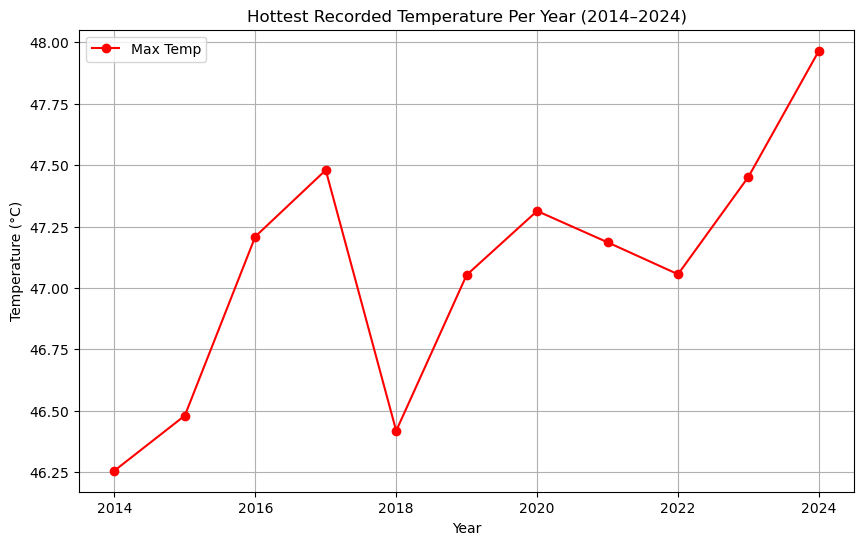

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(
    max_per_year_df["Year"],
    max_per_year_df["Max Temperature (°C)"],
    marker="o",
    color="red",
    linestyle="-",
    label="Max Temp"
)
plt.title("Hottest Recorded Temperature Per Year (2014–2024)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.legend()
plt.savefig(os.path.join(output_folder, "temp-hottest-recorded-per-year.png"), dpi=300, bbox_inches="tight")
plt.show()


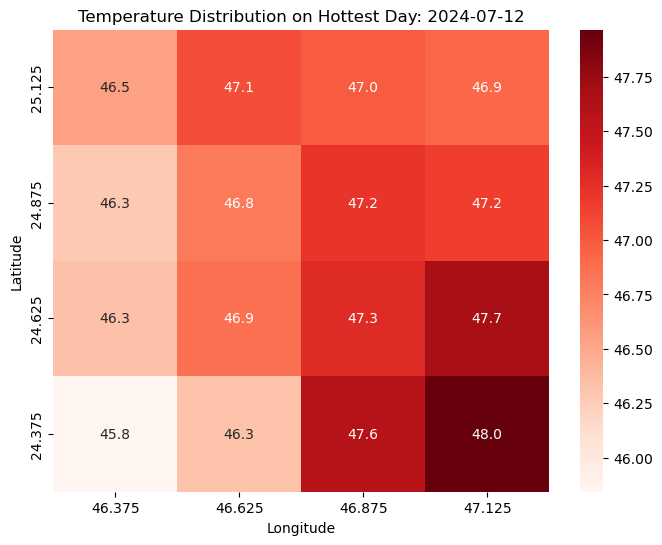

In [13]:
# Find the hottest day on record
hottest_date = max_daily_temperature["valid_time"].isel(
    valid_time=max_daily_temperature.argmax()
).values

# Get the grid data for that day
hottest_grid = daily_max_temp.sel(valid_time=hottest_date)

plt.figure(figsize=(8, 6))
sns.heatmap(
    hottest_grid,
    annot=True,
    fmt=".1f",
    cmap="Reds",
    xticklabels=hottest_grid["longitude"].values,
    yticklabels=hottest_grid["latitude"].values
)
plt.title(f"Temperature Distribution on Hottest Day: {pd.Timestamp(hottest_date).strftime('%Y-%m-%d')}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig(os.path.join(output_folder, "temp-heatmap-hottest-day-2024-07-12.png"), dpi=300, bbox_inches="tight")
plt.show()


In [14]:
# Convert the max daily temperature data to a NumPy array
max_daily_temp_values = max_daily_temperature.values

# Compute the percentiles
percentile_95 = np.percentile(max_daily_temp_values, 95)
percentile_99 = np.percentile(max_daily_temp_values, 99)

# Display results
print(f"95th Percentile Temperature: {percentile_95:.2f} °C")
print(f"99th Percentile Temperature: {percentile_99:.2f} °C")


95th Percentile Temperature: 45.45 °C
99th Percentile Temperature: 46.58 °C


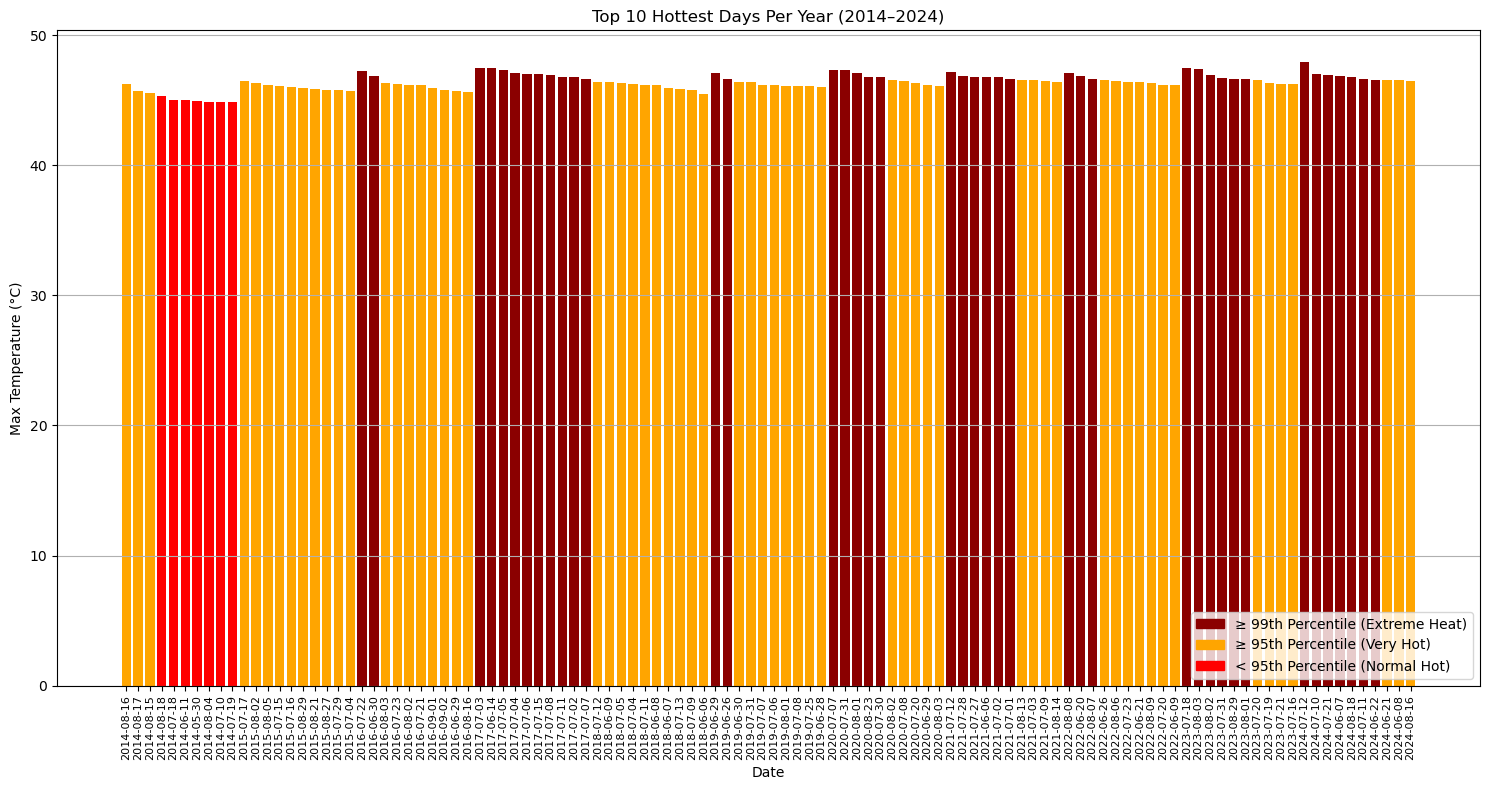

In [15]:
# Ensure max_daily_temperature is already computed
daily_max_temp = temperature_celsius.resample(valid_time="1D").max()
max_daily_temperature = daily_max_temp.max(dim=["latitude", "longitude"])

# Convert to Pandas DataFrame
df_max_temp = max_daily_temperature.to_dataframe(name="Max Temperature (°C)").reset_index()

# Extract the top 10 hottest days per year
df_max_temp["Year"] = df_max_temp["valid_time"].dt.year
top_10_per_year = (
    df_max_temp
    .groupby("Year", group_keys=False)
    .apply(lambda x: x.nlargest(10, "Max Temperature (°C)"), include_groups=False)
    .reset_index(drop=True)
)

# Compute the 95th and 99th percentile thresholds
percentile_95 = np.percentile(df_max_temp["Max Temperature (°C)"], 95)
percentile_99 = np.percentile(df_max_temp["Max Temperature (°C)"], 99)

# Define colors based on thresholds
colors = []
for temp in top_10_per_year["Max Temperature (°C)"]:
    if temp >= percentile_99:
        colors.append("darkred")  # 99th percentile and above (Extreme Heat)
    elif temp >= percentile_95:
        colors.append("orange")  # 95th percentile and above (Very Hot)
    else:
        colors.append("red")  # Normal hot days

# Create the bar chart
plt.figure(figsize=(15, 8))
plt.bar(
    top_10_per_year["valid_time"].dt.strftime("%Y-%m-%d"),
    top_10_per_year["Max Temperature (°C)"],
    color=colors
)

# Customize x-axis
plt.xticks(rotation=90, fontsize=8)
plt.title("Top 10 Hottest Days Per Year (2014–2024)")
plt.xlabel("Date")
plt.ylabel("Max Temperature (°C)")
plt.grid(axis="y")

# Add a legend (Moved to Bottom Right)
legend_patches = [
    Patch(color="darkred", label="≥ 99th Percentile (Extreme Heat)"),
    Patch(color="orange", label="≥ 95th Percentile (Very Hot)"),
    Patch(color="red", label="< 95th Percentile (Normal Hot)")
]
plt.legend(handles=legend_patches, loc="lower right")  # Legend moved to bottom right

# Final adjustments
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "temp-10-hottest-days-per-year.png"), dpi=300, bbox_inches="tight")
plt.show()


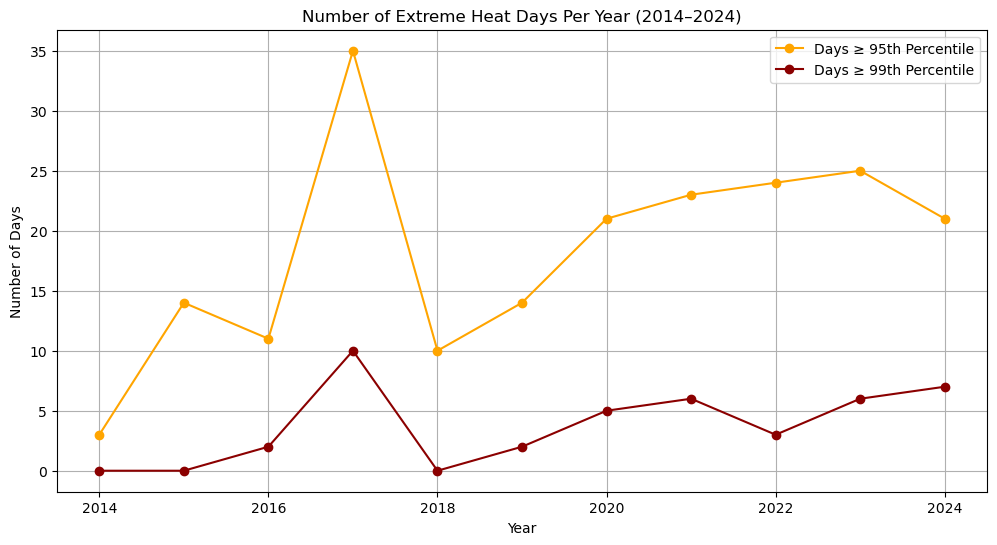

In [16]:
# Add a column to classify whether each day exceeds the 95th and 99th percentiles
max_daily_temp_df["Exceeds 95th"] = max_daily_temp_df["Max Temperature (°C)"] >= percentile_95
max_daily_temp_df["Exceeds 99th"] = max_daily_temp_df["Max Temperature (°C)"] >= percentile_99

# Count the number of extreme heat days per year
extreme_counts = max_daily_temp_df.groupby("Year")[["Exceeds 95th", "Exceeds 99th"]].sum().reset_index()

# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(
    extreme_counts["Year"],
    extreme_counts["Exceeds 95th"],
    marker="o",
    linestyle="-",
    color="orange",
    label="Days ≥ 95th Percentile"
)
plt.plot(
    extreme_counts["Year"],
    extreme_counts["Exceeds 99th"],
    marker="o",
    linestyle="-",
    color="darkred",
    label="Days ≥ 99th Percentile"
)

# Customize the plot
plt.title("Number of Extreme Heat Days Per Year (2014–2024)")
plt.xlabel("Year")
plt.ylabel("Number of Days")
plt.grid()
plt.legend()
plt.savefig(os.path.join(output_folder, "temp-number-extreme-heat-days-per-year.png"), dpi=300, bbox_inches="tight")
plt.show()


In [17]:
# Perform linear regression for 95th percentile days
slope_95, intercept_95, r_value_95, p_value_95, std_err_95 = linregress(
    extreme_counts["Year"], extreme_counts["Exceeds 95th"]
)

# Perform linear regression for 99th percentile days
slope_99, intercept_99, r_value_99, p_value_99, std_err_99 = linregress(
    extreme_counts["Year"], extreme_counts["Exceeds 99th"]
)

# Print results
print("Trend for Days ≥ 95th Percentile:")
print(f"Slope: {slope_95:.2f} days per year")
print(f"R-squared: {r_value_95**2:.2f}")
print(f"P-value: {p_value_95:.4f}")

print("\nTrend for Days ≥ 99th Percentile:")
print(f"Slope: {slope_99:.2f} days per year")
print(f"R-squared: {r_value_99**2:.2f}")
print(f"P-value: {p_value_99:.4f}")

# Check significance
if p_value_95 < 0.05:
    print("\nThe increase in days ≥ 95th percentile is statistically significant (p < 0.05).")
else:
    print("\nThe trend for days ≥ 95th percentile is NOT statistically significant.")

if p_value_99 < 0.05:
    print("The increase in days ≥ 99th percentile is statistically significant (p < 0.05).")
else:
    print("The trend for days ≥ 99th percentile is NOT statistically significant.")


Trend for Days ≥ 95th Percentile:
Slope: 1.45 days per year
R-squared: 0.30
P-value: 0.0836

Trend for Days ≥ 99th Percentile:
Slope: 0.54 days per year
R-squared: 0.29
P-value: 0.0893

The trend for days ≥ 95th percentile is NOT statistically significant.
The trend for days ≥ 99th percentile is NOT statistically significant.


In [18]:
# Step 1: Identify days where max temperature exceeds the 95th percentile
max_daily_temp_df["Heatwave Day"] = max_daily_temp_df["Max Temperature (°C)"] >= percentile_95

# Step 2: Detect consecutive heatwave periods (3+ days)
heatwaves = []
current_heatwave = []

for i, row in max_daily_temp_df.iterrows():
    if row["Heatwave Day"]:
        current_heatwave.append(row)
    else:
        # If a heatwave just ended, check if it lasted at least 3 days
        if len(current_heatwave) >= 3:
            heatwaves.append(pd.DataFrame(current_heatwave))
        current_heatwave = []  # Reset

# Check if the last recorded heatwave met the threshold
if len(current_heatwave) >= 3:
    heatwaves.append(pd.DataFrame(current_heatwave))

# Step 3: Process Heatwave Data
heatwave_data = []

for hw in heatwaves:
    start_date = hw["valid_time"].iloc[0]
    end_date = hw["valid_time"].iloc[-1]
    duration = len(hw)
    max_temps = hw["Max Temperature (°C)"].values  # Max temps per day in the heatwave

    heatwave_data.append({
        "Start Date": start_date,
        "End Date": end_date,
        "Duration (days)": duration,
        "Max Temps Per Day (°C)": list(max_temps)
    })

# Convert to DataFrame
heatwave_df = pd.DataFrame(heatwave_data)

# Display the first few rows of the heatwave dataset
print(heatwave_df.head())

# Print summary stats
print(f"Total Heatwaves Detected: {len(heatwave_df)}")
print(f"Longest Heatwave Duration: {heatwave_df['Duration (days)'].max()} days")
print(f"Average Heatwave Duration: {heatwave_df['Duration (days)'].mean():.2f} days")


  Start Date   End Date  Duration (days)  \
0 2014-08-15 2014-08-17                3   
1 2015-07-15 2015-07-17                3   
2 2016-07-21 2016-07-23                3   
3 2017-06-13 2017-06-15                3   
4 2017-07-02 2017-07-08                7   

                              Max Temps Per Day (°C)  
0  [45.524444580078125, 46.255889892578125, 45.68...  
1  [46.0491943359375, 46.047637939453125, 46.4802...  
2  [46.19390869140625, 47.2091064453125, 46.25280...  
3  [45.788970947265625, 47.436737060546875, 46.33...  
4  [46.771484375, 47.479766845703125, 47.11294555...  
Total Heatwaves Detected: 35
Longest Heatwave Duration: 7 days
Average Heatwave Duration: 4.17 days


In [19]:
# Save heatwave data to a CSV file
heatwave_df.to_csv(os.path.join(output_folder, "heatwave_events-4x4.csv"), index=False)
print("Heatwave events saved to heatwave_events.csv")

Heatwave events saved to heatwave_events.csv


In [20]:
# Step 1: Define your target heatwave dates
heat_dates = [
    "2014-08-16", "2015-07-17", "2016-07-22", "2017-06-14", "2018-06-09",
    "2019-06-29", "2020-06-29", "2021-06-06", "2022-06-09", "2023-07-08", "2024-06-22"
]
heat_dates = [pd.to_datetime(d) for d in heat_dates]

# Step 2: Load reference raster (for transform + CRS)
ref_tif = "reference-raster.tif"
with rasterio.open(ref_tif) as ref:
    transform = ref.transform
    crs = ref.crs

# Step 3: Define and create output folders
output_folder = "Outputs_Heat"
geotiff_dir = os.path.join(output_folder, "geotiffs")
png_dir = os.path.join(output_folder, "pngs")
os.makedirs(geotiff_dir, exist_ok=True)
os.makedirs(png_dir, exist_ok=True)

# Step 4: Export loop
for heat_date in heat_dates:
    year = heat_date.year
    heat_date_str = heat_date.strftime("%Y-%m-%d")

    try:
        temp_grid = daily_max_temp.sel(valid_time=heat_date)
        raster_data = temp_grid.values.squeeze()
    except KeyError:
        print(f"⚠️ No temperature data found for {heat_date_str}")
        continue

    # GeoTIFF export
    temp_grid.rio.write_crs(crs, inplace=True)
    temp_grid.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    tif_path = os.path.join(geotiff_dir, f"heat_{year}_{heat_date_str}.tif")
    temp_grid.rio.to_raster(tif_path, overwrite=True)

    # PNG export
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        raster_data,
        cmap="Reds",
        cbar_kws={'label': 'Max Temp (°C)'},
        xticklabels=temp_grid["longitude"].values,
        yticklabels=temp_grid["latitude"].values
    )
    plt.title(f"Hottest Day of Heatwave: {heat_date_str} ({year})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    png_path = os.path.join(png_dir, f"heat_{year}_{heat_date_str}.png")
    plt.savefig(png_path, dpi=300)
    plt.close()

    print(f"✅ Exported: {heat_date_str} ({year})")


✅ Exported: 2014-08-16 (2014)
✅ Exported: 2015-07-17 (2015)
✅ Exported: 2016-07-22 (2016)
✅ Exported: 2017-06-14 (2017)
✅ Exported: 2018-06-09 (2018)
✅ Exported: 2019-06-29 (2019)
✅ Exported: 2020-06-29 (2020)
✅ Exported: 2021-06-06 (2021)
✅ Exported: 2022-06-09 (2022)
✅ Exported: 2023-07-08 (2023)
✅ Exported: 2024-06-22 (2024)
